In [458]:
#!g1.1
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import cv2
import os
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, random_split
from PIL import Image
from sklearn.metrics import accuracy_score

In [184]:
# #!g1.1
# %rm -r ./data/test/.ipynb_checkpoints
# %rm -r ./data/val/0/.ipynb_checkpoints
# %rm -r ./data/val/1/.ipynb_checkpoints
%rm -r ./data/test/.ipynb_checkpoints
# %rm -r ./data/val/3/.ipynb_checkpoints
# %rm -r ./data/val/4/.ipynb_checkpoints
# %rm -r ./data/val/5/.ipynb_checkpoints

In [459]:
#!g1.1
train_data_path = "./data/train/"
valid_data_path = "./data/valid/"
test_data_path = "./data/test/"

transforms = torchvision.transforms.Compose([
#     torchvision.transforms.Resize(64),
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=transforms)
valid_data = torchvision.datasets.ImageFolder(root=valid_data_path, transform=transforms)
test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=transforms)

valid_data

Dataset ImageFolder
    Number of datapoints: 72
    Root location: ./data/valid/
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [460]:
#!g1.1

# # Create a 90-10 train-validation split.
# train_size = int(0.9 * len(train_data))
# val_size = len(train_data) - train_size

# # Divide the dataset by randomly selecting samples.
# train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# print('{:>5,} training samples'.format(train_size))
# print('{:>5,} validation samples'.format(val_size))

In [461]:
#!g1.1
batch_size = 64
train_data_loader = DataLoader(train_data, batch_size=batch_size)
valid_data_loader = DataLoader(valid_data, batch_size=batch_size)
test_data_loader = DataLoader(test_data, batch_size=batch_size)

In [368]:
#!g1.1
# class SimpleNet(nn.Module):

#     def __init__(self):
#         super(SimpleNet, self).__init__()
#         self.fc1 = nn.Linear(12288, 84)
#         self.fc2 = nn.Linear(84, 50)
#         self.fc3 = nn.Linear(50, 6)

#     def forward(self, x):
#         x = x.view(-1, 12288)
#         x = nn.functional.relu(self.fc1(x))
#         x = nn.functional.relu(self.fc2(x))
#         x = nn.functional.softmax(self.fc3(x), dim=1)
#         return x

In [455]:
#!g1.1
simplenet = SimpleNet()
print(simplenet)

SimpleNet(
  (conv1): Conv2d(3, 12288, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(12288, 4096, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(4096, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (fc): Linear(in_features=256, out_features=6, bias=True)
)


In [456]:
#!g1.1
import torch.optim as optim
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)

epochs = 5

# loss_fn = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    batch_size *= torch.cuda.device_count()
    print("Let's use", torch.cuda.device_count(), "GPUs!")
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Let's use CPU")
print("Batch size: %d" % batch_size)

model = simplenet 
model.to(device)

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device=device):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_data_loader:
            optimizer.zero_grad()
            inputs, target = batch
            inputs = inputs.to(device)
            target = target.to(device)
            output = model(inputs)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item()
        training_loss /= len(train_data_loader)

        model.eval()
        num_correct = 0
        num_examples = 0

        for batch in val_loader:
            inputs, target = batch
            inputs = inputs.to(device)
            target = target.to(device)
            output = model(inputs)
            loss = loss_fn(output, target)
            valid_loss += loss.data.item()
#             print(torch.max(nn.functional.softmax(output, dim=1), dim=1))
#             print(torch.eq(torch.argmax(nn.functional.softmax(output, dim=1), dim=1), target))
            correct = torch.eq(torch.argmax(nn.functional.softmax(output, dim=1), dim=1), target)
            
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader)
        
        print("Epoch: {}, Training Loss {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}".format(epoch, training_loss, valid_loss, 
                                                                                                   num_correct / num_examples))

Let's use 1 GPUs!
Batch size: 64


In [457]:
#!g1.1
train(model, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader)

RuntimeError: CUDA out of memory. Tried to allocate 12.00 GiB (GPU 0; 31.75 GiB total capacity; 15.14 GiB already allocated; 9.24 GiB free; 21.17 GiB reserved in total by PyTorch)

In [311]:
#!g1.1
training_loss

8.528497643470764

In [321]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
                
        self.input_fc = nn.Linear(input_dim, 84)
        self.hidden_fc = nn.Linear(84, 50)
        self.output_fc = nn.Linear(50, output_dim)
        
    def forward(self, x):
        
        #x = [batch size, height, width]
        
        batch_size = x.shape[0]

        x = x.view(batch_size, -1)
        
        #x = [batch size, height * width]
        
        h_1 = nn.functional.relu(self.input_fc(x))
        
        #h_1 = [batch size, 250]

        h_2 = nn.functional.relu(self.hidden_fc(h_1))

        #h_2 = [batch size, 100]

        y_pred = nn.functional.softmax(self.output_fc(h_2), dim=1)
        
        #y_pred = [batch size, output dim]
        
        return y_pred, h_2

In [322]:
INPUT_DIM = 200 * 200
OUTPUT_DIM = 6

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [323]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [324]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,364,640 trainable parameters


In [325]:
import torch.optim as optim
optimizer = optim.AdamW(model.parameters())

In [326]:
criterion = nn.CrossEntropyLoss()

In [327]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [328]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [329]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [330]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [331]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [332]:
EPOCHS = 50

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_data_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_data_loader, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:2} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch:  1 | Epoch Time: 0m 4s
	Train Loss: 1.931 | Train Acc: 9.19%
	 Val. Loss: 1.884 |  Val. Acc: 15.62%
Epoch:  2 | Epoch Time: 0m 1s
	Train Loss: 1.871 | Train Acc: 16.47%
	 Val. Loss: 1.950 |  Val. Acc: 9.38%
Epoch:  3 | Epoch Time: 0m 2s
	Train Loss: 1.902 | Train Acc: 13.60%
	 Val. Loss: 1.893 |  Val. Acc: 14.84%
Epoch:  4 | Epoch Time: 0m 2s
	Train Loss: 1.772 | Train Acc: 27.17%
	 Val. Loss: 1.887 |  Val. Acc: 15.62%
Epoch:  5 | Epoch Time: 0m 2s
	Train Loss: 1.758 | Train Acc: 28.49%
	 Val. Loss: 1.884 |  Val. Acc: 15.62%
Epoch:  6 | Epoch Time: 0m 2s
	Train Loss: 1.753 | Train Acc: 29.04%
	 Val. Loss: 1.882 |  Val. Acc: 16.41%
Epoch:  7 | Epoch Time: 0m 2s
	Train Loss: 1.766 | Train Acc: 27.96%
	 Val. Loss: 1.893 |  Val. Acc: 14.84%
Epoch:  8 | Epoch Time: 0m 2s
	Train Loss: 1.757 | Train Acc: 28.62%
	 Val. Loss: 1.853 |  Val. Acc: 18.75%
Epoch:  9 | Epoch Time: 0m 2s
	Train Loss: 1.751 | Train Acc: 29.04%
	 Val. Loss: 1.884 |  Val. Acc: 15.62%
Epoch: 10 | Epoch Time: 0m 2s


In [640]:
#!g1.1
class CNNNet(nn.Module):
    def __init__(self, num_classes = 6):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=2), 
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 4, kernel_size=5, padding=2),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        self.classifier = nn.Sequential (
            nn.Dropout(),
            nn.Linear(16*6*6, 2048), 
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [641]:
#!g1.1
modelCnn = CNNNet()

In [642]:
#!g1.1

optimizer = optim.AdamW(modelCnn.parameters())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

modelCnn.to(device)
train_losses = []
val_losses = []

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=60, device=device):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, target = batch
            inputs = inputs.to(device)
            target = target.to(device)
            output = model(inputs)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item()
        training_loss /= len(train_loader)
        train_losses.append(training_loss)

        model.eval()
        num_correct = 0
        num_examples = 0

        for batch in val_loader:
            inputs, target = batch
            inputs = inputs.to(device)
            target = target.to(device)
            output = model(inputs)
            loss = loss_fn(output, target)
            valid_loss += loss.data.item()
    #             print(torch.max(nn.functional.softmax(output, dim=1), dim=1))
    #             print(torch.eq(torch.argmax(nn.functional.softmax(output, dim=1), dim=1), target))
            correct = torch.eq(torch.argmax(nn.functional.softmax(output, dim=1), dim=1), target)

            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader)
        val_losses.append(valid_loss)
        print("Epoch: {}, Training Loss {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}".format(epoch, training_loss, valid_loss, 
                                                                                                     num_correct / num_examples))
        if valid_loss < 0.4 and training_loss < 0.5:
            break 

In [643]:
#!g1.1
train(modelCnn, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, valid_data_loader)

Epoch: 0, Training Loss 2.37, Validation Loss: 1.84, accuracy = 0.17
Epoch: 1, Training Loss 1.82, Validation Loss: 1.82, accuracy = 0.17
Epoch: 2, Training Loss 1.80, Validation Loss: 1.81, accuracy = 0.17
Epoch: 3, Training Loss 1.80, Validation Loss: 1.80, accuracy = 0.17
Epoch: 4, Training Loss 1.79, Validation Loss: 1.80, accuracy = 0.17
Epoch: 5, Training Loss 1.79, Validation Loss: 1.79, accuracy = 0.32
Epoch: 6, Training Loss 1.79, Validation Loss: 1.78, accuracy = 0.40
Epoch: 7, Training Loss 1.78, Validation Loss: 1.76, accuracy = 0.44
Epoch: 8, Training Loss 1.80, Validation Loss: 1.78, accuracy = 0.19
Epoch: 9, Training Loss 1.85, Validation Loss: 1.76, accuracy = 0.03
Epoch: 10, Training Loss 1.81, Validation Loss: 1.78, accuracy = 0.42
Epoch: 11, Training Loss 1.78, Validation Loss: 1.77, accuracy = 0.46
Epoch: 12, Training Loss 1.75, Validation Loss: 1.75, accuracy = 0.32
Epoch: 13, Training Loss 1.75, Validation Loss: 1.71, accuracy = 0.32
Epoch: 14, Training Loss 1.72,

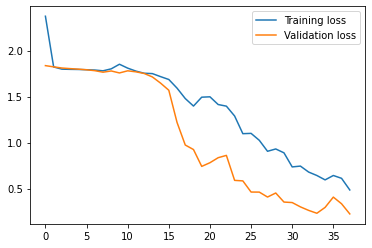

In [644]:
#!g1.1
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [645]:
#!g1.1
pred = []
y_test = []
for batch in test_data_loader:
    inputs, target = batch
    inputs = inputs.to(device)
    target = target.to(device)
    output = modelCnn(inputs)
    softmax = torch.exp(output)
    predictions = torch.argmax(softmax, dim=1)
    # accuracy on validation set
    pred += predictions.tolist()
    y_test += target.tolist()
acc = accuracy_score(pred, y_test)
print(acc)

0.8472222222222222


In [646]:
#!g1.1
import pickle
raw_data = pickle.dumps(modelCnn)
pickle.dump(modelCnn, open('modelCnn_0847.pkl','wb'))

In [630]:
#!g1.1
pred = []
y_test = []
for batch in test_data_loader:
    inputs, target = batch
    inputs = inputs.to(device)
    target = target.to(device)
    output = modelCnn(inputs)
    softmax = torch.exp(output)
    predictions = torch.argmax(softmax, dim=1)
    # accuracy on validation set
    pred += predictions.tolist()
    y_test += target.tolist()
acc = accuracy_score(pred, y_test)
print(acc)

0.7638888888888888


In [631]:
#!g1.1
import pickle
raw_data = pickle.dumps(modelCnn)
pickle.dump(modelCnn, open('modelCnn.pkl','wb'))

In [682]:
#!g1.1
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()
    
        self.cnn_layers = nn.Sequential(
            
        # Defining a 2D convolution layer
        nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Defining another 2D convolution layer
        nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
                )
        
#         self.linear_layers = nn.Sequential(
#         nn.Linear(10000, 6)
#         )

        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        self.linear_layers = nn.Sequential (
            nn.Dropout(),
            nn.Linear(10000, 2048), 
            nn.ReLU(inplace=True),
            nn.Linear(2048, 6)
        )
        
    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [683]:
#!g1.1

# defining the model
model = Net()
# defining the optimizer
optimizer = optim.AdamW(model.parameters())
# defining the loss function
criterion = torch.nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (linear_layers): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=10000, out_features=2048, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=2048, out_features=6, bias=True)
  )
)


In [684]:
#!g1.1
def train(epoch, device=device):
    model.train()
    tr_loss = 0
    val_loss = 0
    epoch_acc = 0
    # getting the training set
    for batch in train_data_loader:
        x_train, y_train = batch

        # converting the data into GPU format
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        optimizer.zero_grad()
        # prediction for training and validation set
        output_train = model(x_train)
        
        
        # computing the training and validation loss
        loss_train = criterion(output_train, y_train)
        loss_train.backward()
        optimizer.step()
        tr_loss += loss_train.item()
    train_losses.append(tr_loss / len(train_data_loader))
        
    for batch in valid_data_loader:
        # getting the validation set
        x_val, y_val = batch
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        output_val = model(x_val)
        loss_val = criterion(output_val, y_val)
        val_loss += loss_val.item()
        acc = calculate_accuracy(output_val, y_val)
        epoch_acc += acc.item()
    val_losses.append(val_loss / len(valid_data_loader))
            
    # printing the validation loss
    print('Epoch : ',epoch+1, '\t', 'loss :', val_loss / len(valid_data_loader), 'acc:', epoch_acc / len(valid_data_loader))
    
    

In [ ]:
#!g1.1
# defining the number of epochs
n_epochs = 70
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : 2.3619704246520996 acc: 0.09375
Epoch :  2 	 loss : 1.7815057039260864 acc: 0.390625
Epoch :  3 	 loss : 1.7791277170181274 acc: 0.53125
Epoch :  4 	 loss : 1.773857831954956 acc: 0.53125
Epoch :  5 	 loss : 1.7845329642295837 acc: 0.53125
Epoch :  6 	 loss : 1.7402083277702332 acc: 0.53125
Epoch :  7 	 loss : 1.7763084173202515 acc: 0.296875
Epoch :  8 	 loss : 1.7249988913536072 acc: 0.3671875
Epoch :  9 	 loss : 1.7241060733795166 acc: 0.15625
Epoch :  10 	 loss : 1.7066225409507751 acc: 0.1875
Epoch :  11 	 loss : 1.6765475273132324 acc: 0.1875
Epoch :  12 	 loss : 1.6588271856307983 acc: 0.1875
Epoch :  13 	 loss : 1.6568848490715027 acc: 0.1875
Epoch :  14 	 loss : 1.63938570022583 acc: 0.1875
Epoch :  15 	 loss : 1.6328867673873901 acc: 0.1875
Epoch :  16 	 loss : 1.6224392652511597 acc: 0.1875
Epoch :  17 	 loss : 1.6193227767944336 acc: 0.1875
Epoch :  18 	 loss : 1.6059862971305847 acc: 0.1875
Epoch :  19 	 loss : 1.6029910445213318 acc: 0.25
Epoch :  20 	

In [ ]:
#!g1.1
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
#!g1.1
pred = []
y_test = []
for batch in test_data_loader:
    inputs, target = batch
    inputs = inputs.to(device)
    target = target.to(device)
    output = model(inputs)
    softmax = torch.exp(output)
    predictions = torch.argmax(softmax, dim=1)
    # accuracy on validation set
    pred += predictions.tolist()
    y_test += target.tolist()
acc = accuracy_score(pred, y_test)
print(acc)

In [522]:
#!g1.1


In [ ]:
#!g1.1


In [454]:
#!g1.1
class SimpleNet(nn.Module):
    def __init__(self, num_classes=6):
        super(SimpleNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12288, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=12288, out_channels=4096, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.pool = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(in_channels=4096, out_channels=1024, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        self.fc = nn.Linear(in_features=256, out_features=num_classes)

    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)

        output = self.conv2(output)
        output = self.relu2(output)

        output = self.pool(output)

        output = self.conv3(output)
        output = self.relu3(output)

        output = self.conv4(output)
        output = self.relu4(output)

        output = output.view(-1, 256)

        output = self.fc(output)

        return output

In [196]:
#!g1.1
class DataSet(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, dataset_dir, transform=transforms.ToTensor()):
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.image_list = []
        self.labels_list = []
        
        for i in range(6):
            label_files = os.listdir(os.path.join(dataset_dir + str(i)))
            if ".ipynb_checkpoints" in label_files:
                label_files.remove(".ipynb_checkpoints")
            try: 
                for j in range(len(label_files)):
                    self.labels_list.append(i)  
                self.image_list += label_files
            except BaseException:
                raise Exception(f'Fail to load {label_files}.')

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.dataset_dir + str(self.labels_list[idx]) + "/" + self.image_list[idx])
#         print(img_path)
        image = Image.open(img_path)
#         print(image)
        if self.transform:
            image = self.transform(image)
        return image, self.labels_list[idx]

1769
(tensor([[[0.7020, 0.7020, 0.6588,  ..., 0.6902, 0.7294, 0.7059],
         [0.7098, 0.6824, 0.6941,  ..., 0.7020, 0.7020, 0.7373],
         [0.6588, 0.6941, 0.7176,  ..., 0.6863, 0.7373, 0.7647],
         ...,
         [0.6235, 0.6431, 0.6235,  ..., 0.6941, 0.6471, 0.6039],
         [0.6392, 0.6549, 0.6353,  ..., 0.7020, 0.6510, 0.6235],
         [0.6431, 0.6353, 0.6549,  ..., 0.6627, 0.6824, 0.6745]]]), 0)
1,592 training samples
  177 validation samples


In [198]:
#!g1.1
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

batch_size = 32

# Create the DataLoaders for our training and validation sets.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

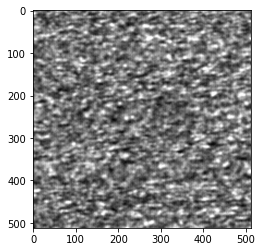

Feature batch shape: torch.Size([32, 1, 512, 512])
Labels batch shape: torch.Size([32])
Label: 0


In [199]:
#!g1.1
# Display image and label of train_dataloader.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

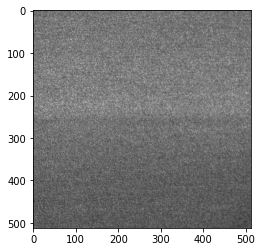

Feature batch shape: torch.Size([32, 1, 512, 512])
Labels batch shape: torch.Size([32])
Label: 2


In [200]:
#!g1.1
# Display image and label of val_dataloader.
val_features, val_labels = next(iter(validation_dataloader))
print(f"Feature batch shape: {val_features.size()}")
print(f"Labels batch shape: {val_labels.size()}")
img = val_features[0].squeeze()
label = val_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [201]:
#!g1.1
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    batch_size *= torch.cuda.device_count()
    print("Let's use", torch.cuda.device_count(), "GPUs!")
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Let's use CPU")
print("Batch size: %d" % batch_size)

Let's use 1 GPUs!
Batch size: 32


In [ ]:
#!g1.1


In [ ]:
#!g1.1


In [211]:
#!g1.1
num_steps = 10

for step in range(num_steps):
    start_time = time.time()
    
    for batch, label in train_dataloader:
        

#     phase = 'train'
#     net.train()
#     if step % val_step_interval == 0:
#         phase = 'val'
#         net.eval()


IndentationError: expected an indented block (<ipython-input-93-5cb9f9c28f6c>, line 7)

In [ ]:
#!g1.1


In [4]:

classes = ('0', '1', '2', '3',
           '4', '5')

Extracting ./data/train/0/cifar-10-python.tar.gz to ./data/train/0
Extracting ./data/train/1/cifar-10-python.tar.gz to ./data/train/1
Extracting ./data/train/2/cifar-10-python.tar.gz to ./data/train/2
Extracting ./data/train/3/cifar-10-python.tar.gz to ./data/train/3


Extracting ./data/train/4/cifar-10-python.tar.gz to ./data/train/4
Extracting ./data/train/5/cifar-10-python.tar.gz to ./data/train/5


In [5]:
#!g1.1
len(dataset)

6

In [7]:
#!g1.1
len(dataset[0])

50000

In [ ]:
#!g1.1
